
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/053_Monte_Carlo_Simulation.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/53_Monte_Carlo_Simulation.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🎲 Symulacja Monte Carlo: Dr Strange i Multiwersum

Nikt nie zna przyszłości. Ale jeśli znamy statystykę przeszłości (średni wzrost i zmienność), możemy wygenerować **tysiące możliwych scenariuszy**.

Zamiast pytać: "Ile zarobię?", pytamy: "Jaka jest szansa, że stracę wszystko?".

**Scenariusz:**
*   Masz 1000 zł.
*   Inwestujesz w akcje, które historycznie rosną 10% rocznie (średnio).
*   Ale mają dużą zmienność (Volatility) - ceny skaczą o 20% góra/dół.

Uruchomimy symulację na 1 rok (252 dni sesyjne) **tysiąc razy**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia
SIMULATIONS = 1000   # Ile alternatywnych wszechświatów tworzymy?
DAYS = 252           # Dni handlowe w roku
START_PRICE = 1000   # Początkowy kapitał

# Parametry rynku (historyczne założenia)
MU = 0.10            # Oczekiwany zwrot roczny (10%)
SIGMA = 0.20         # Zmienność (Ryzyko - 20%)

print(f"Startujemy z {START_PRICE} PLN.")
print(f"Cel: Symulacja {SIMULATIONS} scenariuszy na rok do przodu.")

Startujemy z 1000 PLN.
Cel: Symulacja 1000 scenariuszy na rok do przodu.


## Matematyka: Geometryczne Ruchy Browna

Nie wchodząc głęboko w równania różniczkowe: cena jutro to cena dziś pomnożona przez pewien "szok".
$$ P_t = P_{t-1} \times e^{(drift + shock)} $$

*   **Drift (Trend):** To ta część, która pcha cenę w górę (nasze 10% zysku).
*   **Shock (Losowość):** To losowa liczba z rozkładu normalnego, pomnożona przez zmienność ($\sigma$). Raz na plus, raz na minus.

In [2]:
np.random.seed(42)

# Tworzymy tablicę wyników [Dni, Symulacje]
# Każda kolumna to jedna historia alternatywna
price_paths = np.zeros((DAYS, SIMULATIONS))
price_paths[0] = START_PRICE

# Generujemy losowe zmiany dzienne (Return)
dt = 1 / DAYS # Krok czasowy (1 dzień)

for t in range(1, DAYS):
    # Losowy szok dla każdej symulacji
    shock = np.random.normal(0, 1, SIMULATIONS)
    
    # Wzór na zmianę ceny (Drift + Shock)
    # Drift: (mu - 0.5 * sigma^2) * dt
    # Shock: sigma * sqrt(dt) * Z
    drift = (MU - 0.5 * SIGMA**2) * dt
    diffusion = SIGMA * np.sqrt(dt) * shock
    
    # Aktualizacja ceny
    price_paths[t] = price_paths[t-1] * np.exp(drift + diffusion)

print("Symulacja zakończona.")
print(f"Kształt danych: {price_paths.shape} (Dni x Scenariusze)")

Symulacja zakończona.
Kształt danych: (252, 1000) (Dni x Scenariusze)


## Wizualizacja: Stożek Niepewności

Narysujmy pierwsze 50 symulacji.
Zobaczysz, że wszystkie zaczynają się w punkcie 1000, ale potem rozjeżdżają się jak spaghetti.

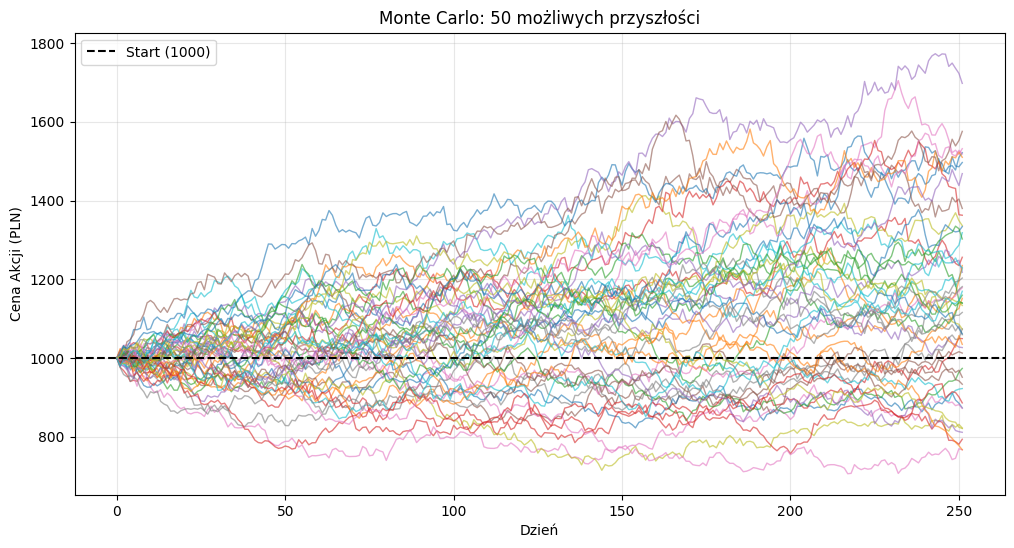

In [3]:
plt.figure(figsize=(12, 6))
# Rysujemy pierwsze 50 ścieżek
plt.plot(price_paths[:, :50], lw=1, alpha=0.6)

plt.title("Monte Carlo: 50 możliwych przyszłości")
plt.xlabel("Dzień")
plt.ylabel("Cena Akcji (PLN)")
plt.grid(True, alpha=0.3)
plt.axhline(START_PRICE, color='k', linestyle='--', label='Start (1000)')
plt.legend()
plt.show()

## Analiza Ryzyka: Histogram Końcowy

Spojrzeliśmy na ścieżki. Teraz spójrzmy na **koniec roku** (ostatni dzień).
Gdzie wylądowaliśmy w tych 1000 symulacjach?

Obliczymy **VaR (Value at Risk)** na poziomie 95%.
To liczba, która mówi: *"W 95% przypadków nie będzie gorzej niż..."*.

Średni wynik: 1105.84 PLN (Zysk: 105.84)
Najlepszy scenariusz: 1948.50 PLN (To the moon! 🚀)
Najgorszy scenariusz: 599.42 PLN (Bankructwo ☠️)
------------------------------
VaR (95%): 784.54 PLN
Oznacza to, że masz 95% pewności, że nie skończysz z kwotą mniejszą niż 784.54.
Ryzykowana kwota: 215.46 PLN.


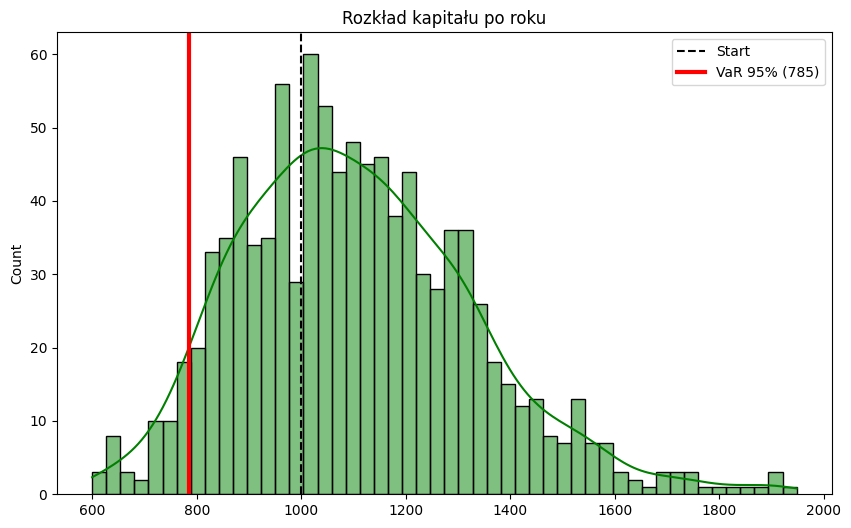

In [4]:
# Bierzemy ceny z ostatniego dnia
final_prices = price_paths[-1]

# Statystyki
mean_final = np.mean(final_prices)
min_final = np.min(final_prices)
max_final = np.max(final_prices)

# Value at Risk (5% najgorszych scenariuszy)
# 5. percentyl oznacza: 5% wyników jest niższych od tej liczby
var_95 = np.percentile(final_prices, 5)

print(f"Średni wynik: {mean_final:.2f} PLN (Zysk: {mean_final - START_PRICE:.2f})")
print(f"Najlepszy scenariusz: {max_final:.2f} PLN (To the moon! 🚀)")
print(f"Najgorszy scenariusz: {min_final:.2f} PLN (Bankructwo ☠️)")
print("-" * 30)
print(f"VaR (95%): {var_95:.2f} PLN")
print(f"Oznacza to, że masz 95% pewności, że nie skończysz z kwotą mniejszą niż {var_95:.2f}.")
print(f"Ryzykowana kwota: {START_PRICE - var_95:.2f} PLN.")

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(final_prices, kde=True, color='green', bins=50)
plt.axvline(START_PRICE, color='k', linestyle='--', label='Start')
plt.axvline(var_95, color='red', linestyle='-', linewidth=3, label=f'VaR 95% ({var_95:.0f})')
plt.title("Rozkład kapitału po roku")
plt.legend()
plt.show()

## 🧠 Podsumowanie: Zarządzanie Ryzykiem

Monte Carlo to potężne narzędzie, bo pozwala "przeżyć" 1000 lat w jedną sekundę.

**Co nam to dało?**
Wiemy, że średnio zarobimy (średnia wyszła > 1000).
ALE wiemy też, że istnieje realne ryzyko (czerwona linia VaR), że skończymy z kwotą np. 700 zł.

**Gdzie się tego używa?**
1.  **Finanse:** Wycena opcji, ryzyko portfela.
2.  **Inżynieria:** Wytrzymałość mostu (losujemy siłę wiatru, jakość betonu).
3.  **Biznes:** Prognozowanie sprzedaży (losujemy popyt, ceny konkurencji).

Zamiast zgadywać jedną liczbę, podejmujesz decyzję w oparciu o prawdopodobieństwo.